In [1]:
from skimage.transform import resize
import SimpleITK as sitk
import cv2
import pydicom
import numpy as np
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
from skimage.measure import label, regionprops, find_contours
from scipy.ndimage import map_coordinates
from skimage.morphology import remove_small_objects
from ipywidgets import interact, widgets
from IPython.display import Image , display, clear_output

## Useful Functions.

In [2]:
def show_slice(img,r_slice=0):
    if r_slice == 0:
        r_slice = [np.random.randint(1,img.shape[i]) for i in [0,1,2]]
    plt.figure(figsize=(24,12))
    plt.subplot(1,3,1)
    plt.imshow(img[r_slice[0],:,:],cmap="gray")
    plt.title("xy")

    plt.subplot(1,3,2)
    plt.imshow(img[:,r_slice[1],:],cmap="gray")
    plt.title("xz")

    plt.subplot(1,3,3)
    plt.imshow(img[:,:,r_slice[2]],cmap="gray")
    plt.title("yz")
    
    plt.show()

def to_isotropic(sitk_img, target_spacing=[1,1,1]):

    # image = sitk.GetImageFromArray(dicom_array)
    # Create a new spacing and size for the resampled image
    new_spacing = target_spacing
    new_size = [int(sz * spc / new_spc) for sz, spc, new_spc in zip(sitk_img.GetSize(), sitk_img.GetSpacing(), new_spacing)]
    # Resample the image to the new spacing and size
    resampled_image = sitk.Resample(sitk_img, new_size, sitk.Transform(), sitk.sitkLinear, sitk_img.GetOrigin(), new_spacing)
    # dicom_array_resampled = sitk.GetArrayFromImage(resampled_image)
    
    return resampled_image

def read_dcm (path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image_np = sitk.GetArrayFromImage(image)
    return image_np, image

Reading the dicom file and showing single slice

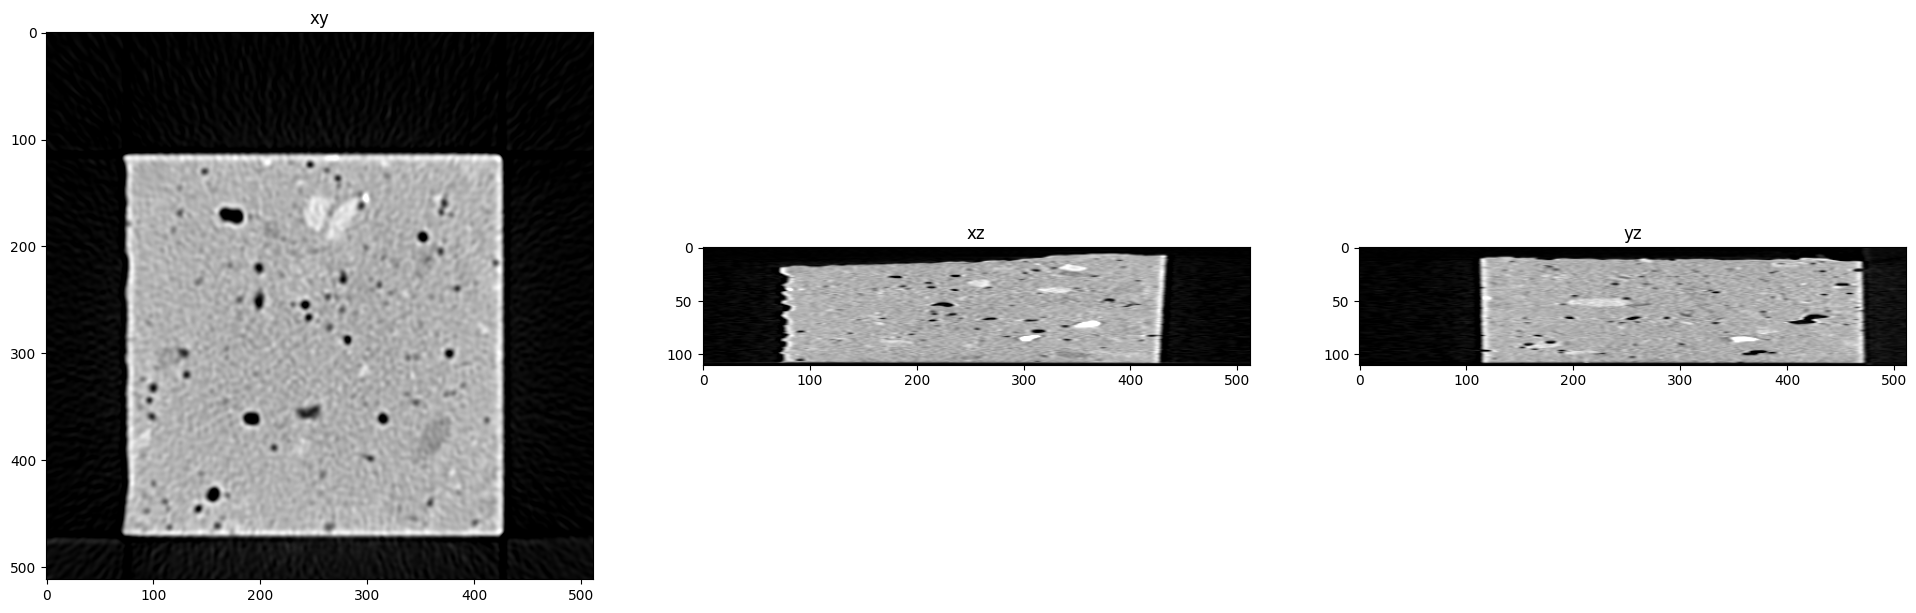

In [3]:
#Reading the whole dicom series 
path = os.path.join(os.getcwd(),"Hossz","Hossz")
image_np, image = read_dcm(path)

show_slice(image_np)


Convert to isotropic voxel 0.2mm x0.2mm x0.2mm pixle spacing

Image Size:  (500, 500, 660)
Pixel Spacing:  (0.2, 0.2, 0.2)
Image Origin:  (-51.90234375, -168.90234375, -109.3)


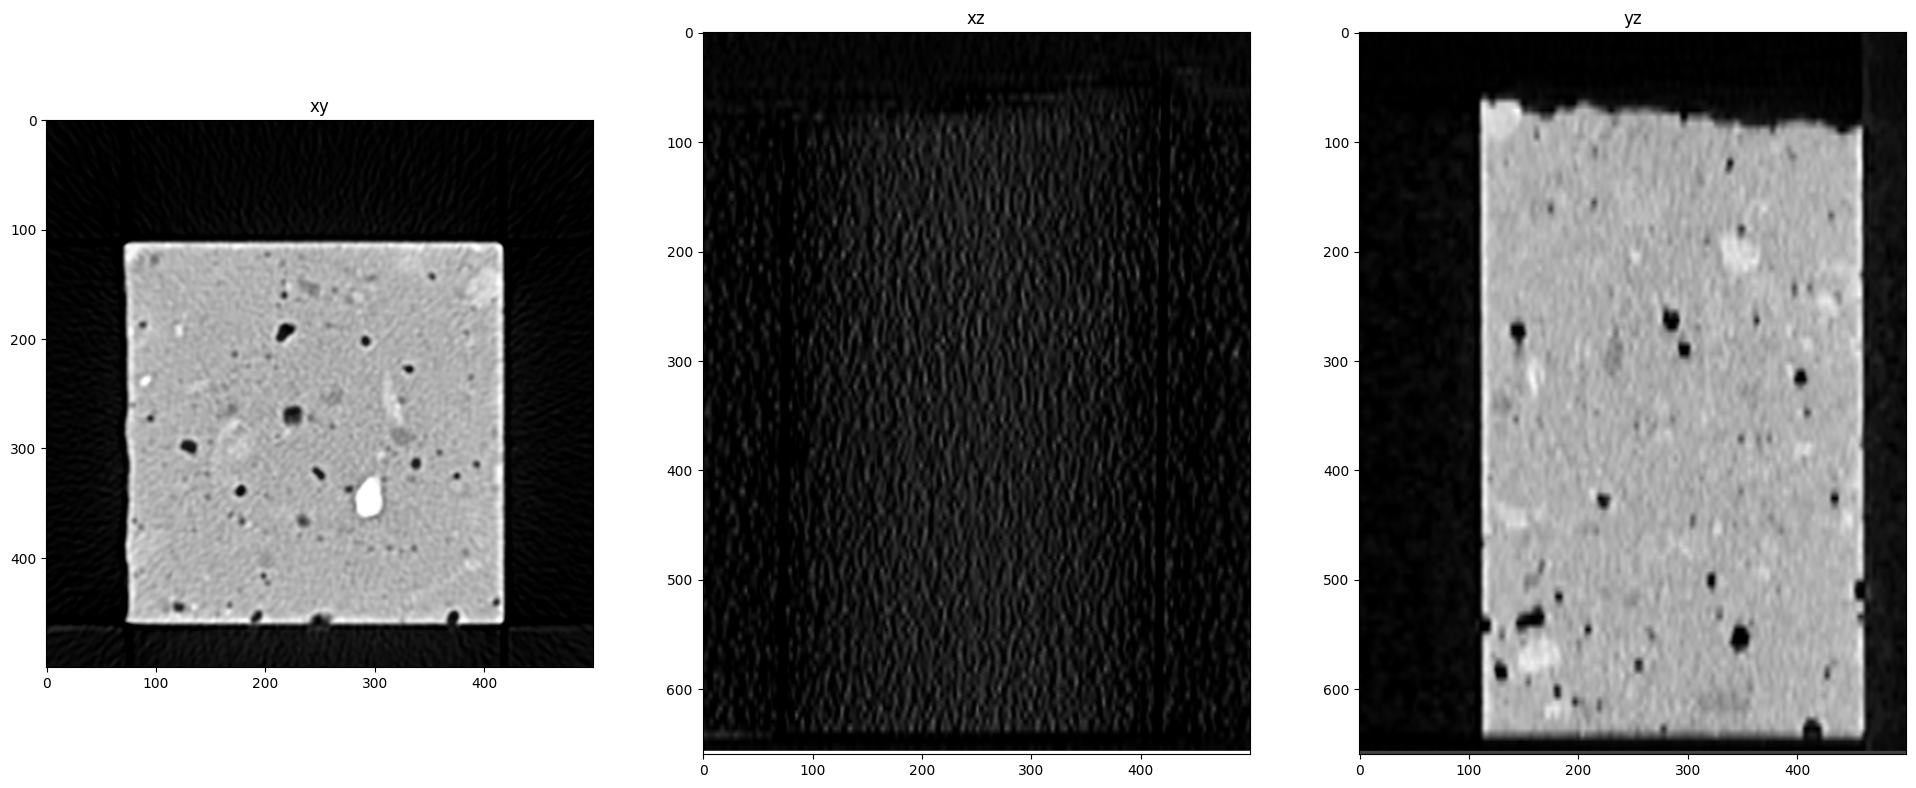

In [4]:
image = to_isotropic(image,[0.2,0.2,0.2])
print("Image Size: ",image.GetSize())
print("Pixel Spacing: ",image.GetSpacing())
print("Image Origin: ",image.GetOrigin())
spacing = image.GetSpacing()

show_slice(sitk.GetArrayFromImage(image))

Trimming the whole volume to eliminate the background 

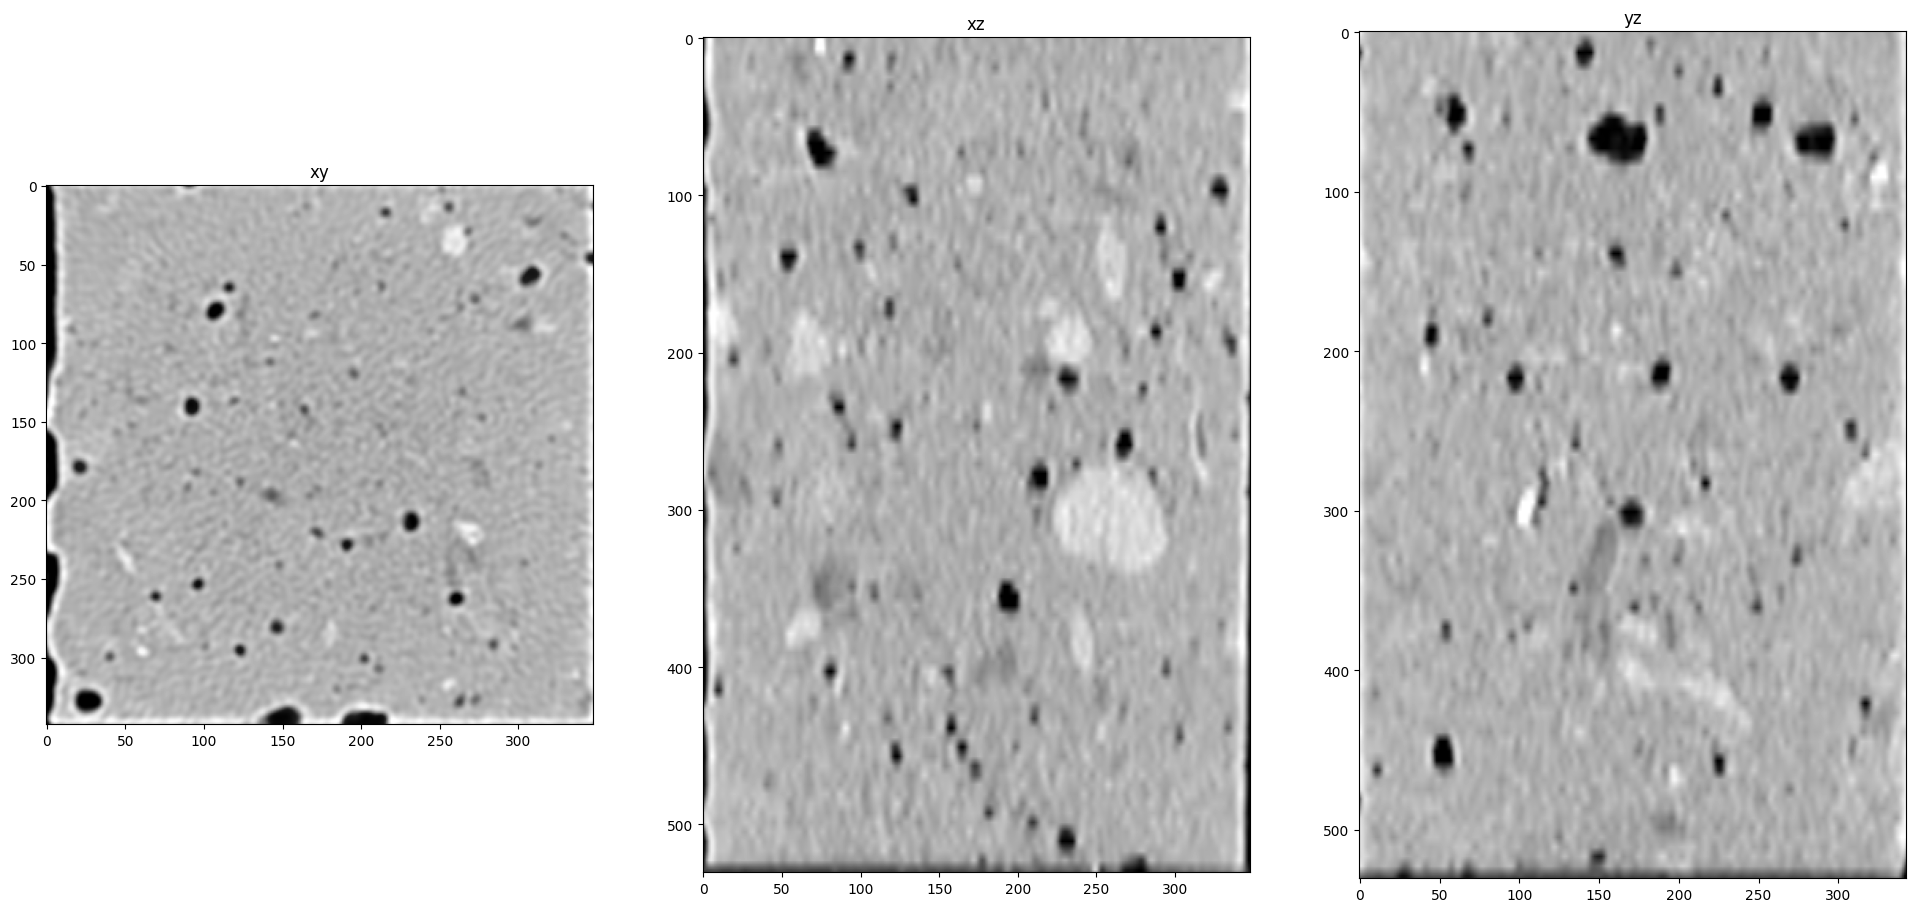

In [5]:
# Trimming the volume
image_np = sitk.GetArrayFromImage(image)
binary_mask = (image_np>0).astype(np.uint8)
labeled_mask = label(binary_mask)
regions = regionprops(labeled_mask)
max_region = max(regions,key=lambda region: region.area)
min_slice, min_row, min_col, max_slice, max_row, max_col = max_region.bbox
cropped = image_np[min_slice+100:max_slice-5,min_row+6:max_row-5,min_col+6:max_col-5]
show_slice(cropped)

## Porosity Analysis:
Calculating the Porosity ratio, Max, Min, and average hole areas in all slices through 3 directions.

Analysis through X axis:


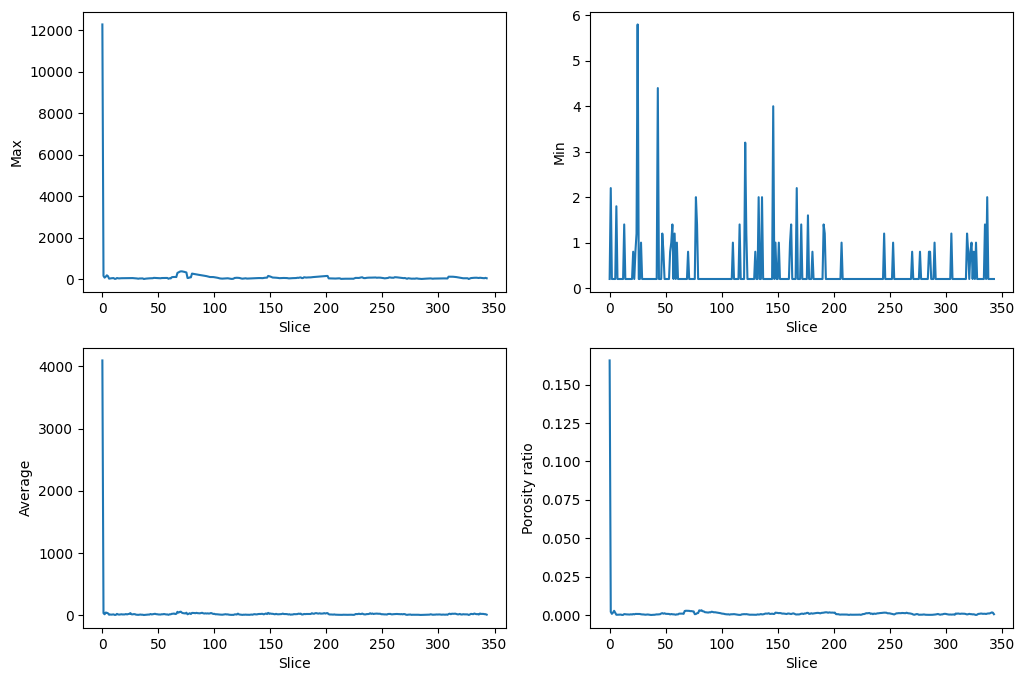

Analysis through Y axis:


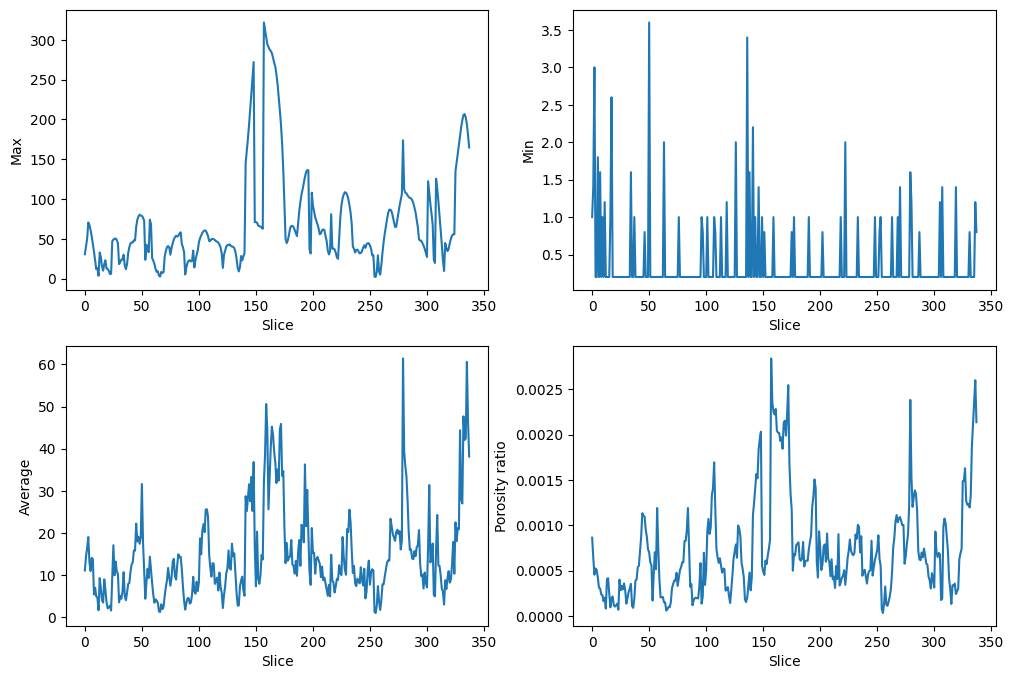

Analysis through Z axis:


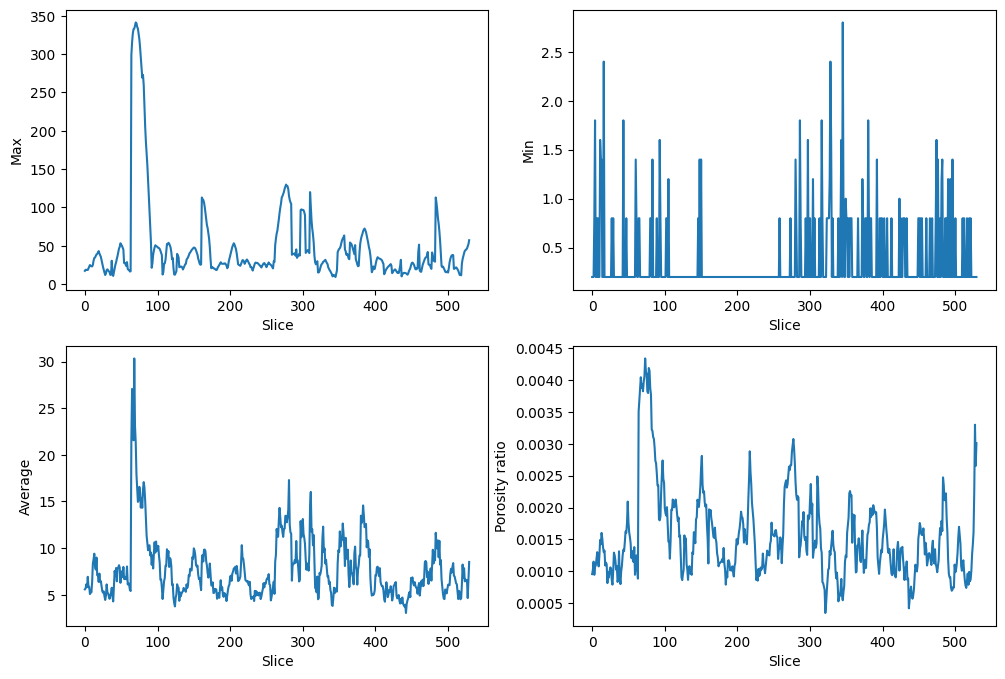

In [6]:
def Porosity_analysis(vol,axis=0):
    ax = "X" if axis==0 else "Y" if axis==1 else "Z"
    index = 0 if axis==2 else 2 if axis == 0 else 1 
    print(f"Analysis through {ax} axis:")
    max_area_list = list()
    min_area_list = list()
    avg_area_list = list()
    porosity_ratio_list = list()
    for i in range(vol.shape[index]-1):
        #trimming single slice to get rid of the background
        sample_slice = vol[:,:,i] if axis==0 else vol[:,i,:] if axis == 1 else vol[i,:,:]
        binary_mask = (sample_slice>0).astype(np.uint8)
        labeled_mask = label(binary_mask)
        regions = regionprops(labeled_mask)
        max_region = max(regions,key=lambda region: region.area)
        min_row, min_col, max_row, max_col = max_region.bbox
        sample_slice = sample_slice[min_row:max_row+1,min_col:max_col+1]


        hole_mask = (sample_slice < 600).astype(np.uint8)
        labeled_holes, num_holes = label(hole_mask, return_num=True)
        regions = regionprops(labeled_holes)

        non_hole_regions = [region for region in regions if region.eccentricity>0.7]
        hole_regions = [region for region in regions if region.eccentricity<=0.7]

        background_area = sum([hole.area for hole in non_hole_regions])
        areas = [hole.area for hole in hole_regions]

        if len(areas) >2:
            porosity_ratio = (sum(areas)/((sample_slice.shape[0]*sample_slice.shape[1]) - background_area))*spacing[0]
            max_area_list.append(max(areas)*spacing[0])
            min_area_list.append(min(areas)*spacing[0])
            avg_area_list.append(sum(areas)/len(areas)*spacing[0])
            porosity_ratio_list.append(porosity_ratio)

    area_dict= {"Max":max_area_list ,"Min":min_area_list,"Average":avg_area_list,"Porosity ratio":porosity_ratio_list}
    area_df = pd.DataFrame(area_dict)
    plt.figure(figsize=(12,8))
    plt.title(f"Analysis through {ax} axis:")
    for i,val in enumerate(area_df.columns):
        plt.subplot(2,2, i+1)
        sns.lineplot(data=area_df, x=area_df.index,y=val)
        plt.xlabel("Slice")
        
    plt.show()

for i in range(3):
    Porosity_analysis(cropped,axis=i)
    

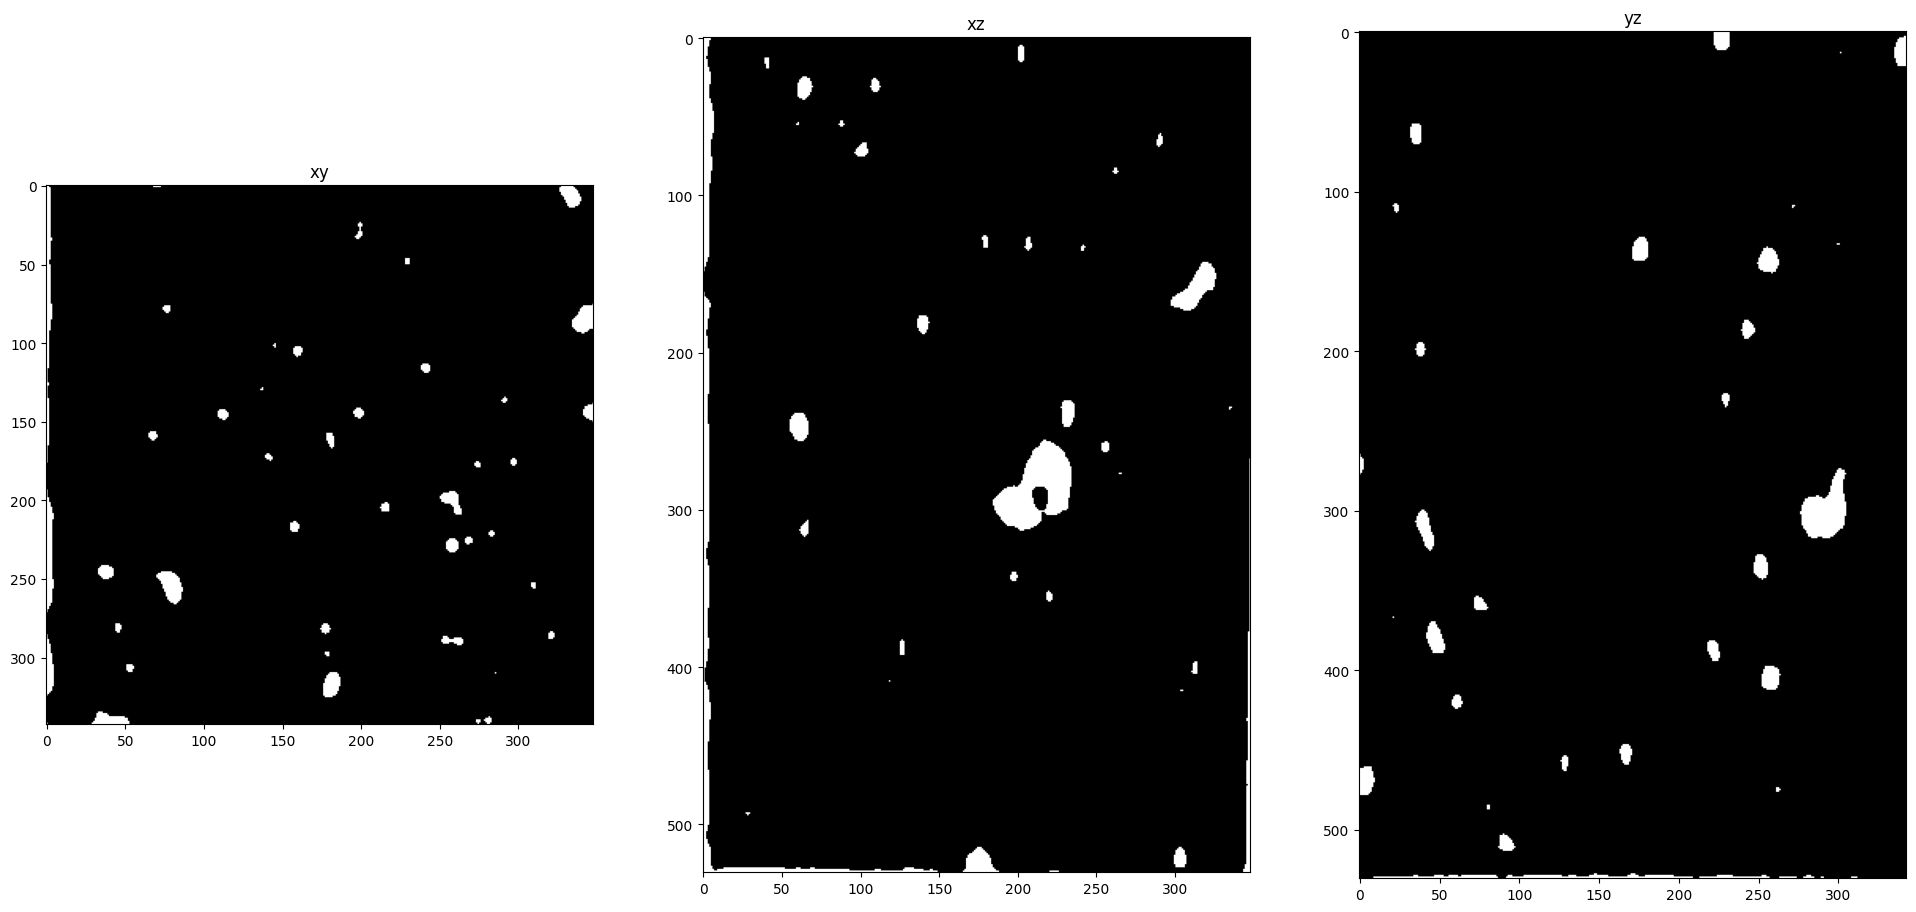

Number of holes: 1975


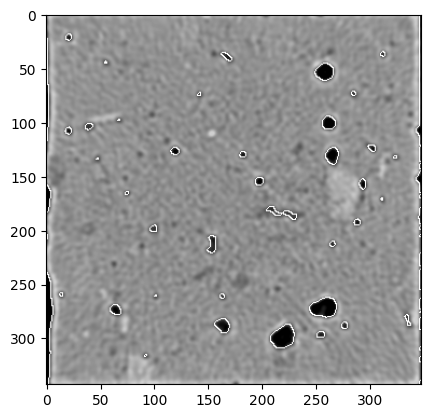

In [7]:

max_vol_mm = 500
max_vol_vox = max_vol_mm//image.GetSpacing()[0]
# print(max_vol_vox)
hole_mask = (cropped < 600).astype(np.uint8)
labeled_holes, num_holes = label(hole_mask, return_num=True)
regions = regionprops(labeled_holes)
vols = [regions[i].area_filled for i in range(labeled_holes.max())]
holes = [vol for vol in vols if vol < max_vol_vox]
num_holes = len(holes)
# print(regions[0].centroid)
show_slice(hole_mask)
# Count the circular holes 
print(f"Number of holes: {num_holes}")
# print(labeled_holes[:5])

# Find and store contours in 2D slices
contours_2d = []
for z in range(labeled_holes.shape[0]):
    contour = find_contours(labeled_holes[z], level=0.5)
    contours_2d.append(contour)

# Create a copy of the cropped volume for drawing contours
cropped_with_contours = np.copy(cropped)

# Project the 2D contours into 3D space
for z, contours in enumerate(contours_2d):
    for contour in contours:
        for coords in contour:
            y, x = coords  # Coordinates are in (y, x) order in 2D
            cropped_with_contours[z, int(y), int(x)] = 4000  # Set contour pixels to 255 (white)

# Display or save the image as needed
# (You can replace this with your preferred method)
# Example: Display a slice of the volume with contours
slice_index = cropped_with_contours.shape[0] // 2  # Choose a central slice
plt.imshow(cropped_with_contours[slice_index], cmap='gray')
plt.show()

## Distance Analysis:

1. the next few cells will go through extracting sample lines across the 3 directions in two way: 
    * Parallel to the main axes x,y,z
    * Using diagonal lines covering all possible combinations through each plane
2. then calculating the distance profile for each line.
3. distance factor (After consulting with the supervisor)

Helper Functions:
1. convert every sample line to distance factor list.
2. extracting sample line between two determined coordinates.

In [8]:
def line_to_dsf(line):
    counter = 1
    dsf_list = []
    indicator = line[0]
    for i in range(1,len(line)):
        if indicator == line[i]:
            counter +=1
        else:
            dsf_list.append(counter)
            counter = 1
            indicator = line[i]
    dsf_list.append(counter)
    return dsf_list

#Sample test for the function
print(".........................\n Testing line to distance factor function ")
l = [[1, 1, 1, 1, 0, 0, 0, 1, 1],[1, 1, 1, 0, 0, 0],[1,0,0,1,1,1,1,0]] 
for line in l:
    print(line)
    print(line_to_dsf(line))



def line_sample_2(image,coords,axis=0):

    from skimage.draw import line

    start,end = coords
    y_size,x_size = image.shape
    
    # Get the coordinates of the line
    # for Y sampling
    if axis == 1:
        rr, cc = line(start, 0, end, x_size-1)
    # for X sampling
    else: 
        rr, cc = line(0, start, y_size-1, end)
    # Extract the values along the line
    line_data = image[rr, cc]
    
    return line_data

#Sample test for the sampling
print("\n.........................\n Testing line sampling function ")
arr = np.random.randint(1,20,size=(10,10))
print(arr)
print("..................")
print(line_sample_2(arr,(0,6)))


.........................
 Testing line to distance factor function 
[1, 1, 1, 1, 0, 0, 0, 1, 1]
[4, 3, 2]
[1, 1, 1, 0, 0, 0]
[3, 3]
[1, 0, 0, 1, 1, 1, 1, 0]
[1, 2, 4, 1]

.........................
 Testing line sampling function 
[[19 14 18 12  2  2  1 14 10  1]
 [ 8  2  8 12  5  8  6  4 13  3]
 [13 18  3 17 10  4 13 14 16  6]
 [15  8  5 14  6  1 14  6  1  7]
 [ 1 13 14 10 19 13  7 12 14 19]
 [ 4 11  2 13 13  9 12  4  5  9]
 [16 13  3  9 10 14  4  9 10  4]
 [ 5 13 11 15  8  6 12 16  1 16]
 [ 8  8  4  8  9  2  3  1  8  3]
 [ 7  3  1 16 13  3 14 17 10  6]]
..................
[19  2 18  5 10 13 10  6  2 14]


### Distance analysis function (Parallel sampling lines):
1. extracting plane/slice
2. sampling lines in every slice
3. storing distance factor for every line in a list of lists

In [9]:
def distance_analysis_all(vol):

    # ax,index = ("X",2) if axis==0 else ("Y",1) if axis==1 else ("Z",0)
    # index = 0 if axis==2 else 2 if axis == 0 else 1 
    # print(f"Analysis through {ax} axis:")
    from itertools import product
    spacing = 0.2
    dsf_dict = {"dsf_x":[],"dsf_y":[],"dsf_z":[]}
    # print("\n .....Starting of the process.... \n")

    #Loop through the z slices 
    print(".....Starting of analysis, Y and X axes.... \n")
    for i in range(0,vol.shape[0],10):

        #Taking sample slice
        sample_slice = vol[i,:,:] 
        #Getting the mask 
        hole_mask = (sample_slice < 600).astype(np.uint8)

        #extracting all possible combinations
        y_list = list(range(0,hole_mask.shape[0],20))
        line_coords_y = list(product(y_list,y_list))
        # print(line_coords[:10]) 
        #sampling along y
        for coords in line_coords_y :

            # sample_line = hole_mask[i,:].flatten()
            # dsf = line_to_dsf(sample_line.tolist())
            # dsf = list(map(lambda x: x*spacing, dsf))
            # dsf_dict["dsf_y"].append(dsf)
            dsf_dict["dsf_y"].append(list(map(lambda x : round(x*spacing,ndigits=3) ,line_to_dsf(line_sample_2(hole_mask,coords=coords,axis=1)))))

        #sampling along x
            
        #extracting all possible combinations
        x_list = list(range(0,hole_mask.shape[1],20))
        line_coords_x = list(product(x_list,x_list))
        #print("\n .....Starting of the analysis, X axis.... \n")
        for coords in line_coords_x:

            # sample_line = hole_mask[:,i].flatten()
            
            dsf_dict["dsf_x"].append(list(map(lambda x : round(x*spacing,ndigits=3) ,line_to_dsf(line_sample_2(hole_mask,coords=coords,axis=0)))))
    
    #Slicing through x axis
    print("\n .....Starting of the analysis, Z axis.... \n")
    for i in range(0,vol.shape[2],10):
        
        #Taking sample slice
        sample_slice = vol[:,:,i] 
        #Getting the mask 
        hole_mask = (sample_slice < 600).astype(np.uint8)

        #extracting all possible combinations
        z_list = list(range(0,hole_mask.shape[0],20))    
        line_coords_z = list(product(z_list,z_list))

        #sampling along 
        
        for i in line_coords_z:
            # sample_line = hole_mask[i,:].flatten()
            
            dsf_dict["dsf_z"].append(list(map(lambda x : round(x*spacing,ndigits=3) ,line_to_dsf(line_sample_2(hole_mask,coords=coords,axis=0)))))
    
    dsf_df = pd.DataFrame.from_dict(dsf_dict,orient="index")
    dsf_df = dsf_df.transpose()
    return dsf_df,dsf_dict

        # print (type(hole_mask))
        # print(hole_mask.shape)

#Running for the given volume
df,dsf_dict = distance_analysis_all(cropped)
# df.head()
for key,value in dsf_dict.items():
    print(f"sample data from {key}")
    print(value[:3])
    print("..........................")    

.....Starting of analysis, Y and X axes.... 


 .....Starting of the analysis, Z axis.... 

sample data from dsf_x
[[28.8, 1.4, 10.6, 5.0, 22.8], [10.2, 2.8, 6.8, 48.8], [6.8, 61.8]]
..........................
sample data from dsf_y
[[0.6, 69.0], [0.6, 69.0], [0.6, 69.0]]
..........................
sample data from dsf_z
[[23.2, 5.2, 58.2, 15.4, 4.2], [23.2, 5.2, 58.2, 15.4, 4.2], [23.2, 5.2, 58.2, 15.4, 4.2]]
..........................


### Distance analysis function (Sampling lines between two determined points):
1. extracting plane/slice
2. sampling lines in every slice
3. storing distance factor for every line in a list of lists

In [10]:
def distance_analysis_parallel_lines(vol):

    # ax,index = ("X",2) if axis==0 else ("Y",1) if axis==1 else ("Z",0)
    # index = 0 if axis==2 else 2 if axis == 0 else 1 
    # print(f"Analysis through {ax} axis:")

    spacing = 0.2
    dsf_dict = {"dsf_x":[],"dsf_y":[],"dsf_z":[]}

    #Loop through the z slices 
    for i in range(vol.shape[0]):

        #Taking sample slice
        sample_slice = vol[i,:,:] 
        #Getting the mask 
        hole_mask = (sample_slice < 600).astype(np.uint8)

        #sampling along y
        
        for i in range(hole_mask.shape[0]):
            sample_line = hole_mask[i,:].flatten()
            # dsf = line_to_dsf(sample_line.tolist())
            # dsf = list(map(lambda x: x*spacing, dsf))
            # dsf_dict["dsf_y"].append(dsf)
            dsf_dict["dsf_y"].append(list(map(lambda x : round(x*spacing,ndigits=3) ,line_to_dsf(sample_line.tolist()))))
        #sampling along x
        for i in range(hole_mask.shape[1]):
            sample_line = hole_mask[:,i].flatten()
            dsf_dict["dsf_x"].append(list(map(lambda x : round(x*spacing,ndigits=3) ,line_to_dsf(sample_line.tolist()))))
    
    for i in range(vol.shape[2]):
        
        #Taking sample slice
        sample_slice = vol[:,:,i] 
        #Getting the mask 
        hole_mask = (sample_slice < 600).astype(np.uint8)

        #sampling along z
        for i in range(hole_mask.shape[0]):
            sample_line = hole_mask[i,:].flatten()
            dsf_dict["dsf_z"].append(list(map(lambda x : round(x*spacing,ndigits=3) ,line_to_dsf(sample_line.tolist()))))
    
    dsf_df = pd.DataFrame.from_dict(dsf_dict,orient="index")
    dsf_df = dsf_df.transpose()
    return dsf_df,dsf_dict

        # print (type(hole_mask))
        # print(hole_mask.shape)

#Running for the given volume
import pprint
df,dsf_dict = distance_analysis_parallel_lines(cropped)
# df.head()
for key,value in dsf_dict.items():
    print(f"sample data from {key}")
    print(value[:3])
    print("..........................")    

sample data from dsf_x
[[28.8, 1.4, 10.6, 5.0, 22.8], [25.4, 4.8, 10.2, 5.4, 6.0, 1.6, 3.8, 1.0, 10.4], [11.0, 1.4, 12.6, 5.4, 9.8, 5.6, 5.6, 2.6, 2.6, 1.8, 9.2, 0.8, 0.2]]
..........................
sample data from dsf_y
[[0.6, 69.0], [0.8, 68.8], [0.8, 68.8]]
..........................
sample data from dsf_z
[[28.8, 1.4, 10.6, 5.0, 22.8], [28.6, 1.6, 10.6, 5.0, 22.8], [28.4, 2.0, 10.2, 5.4, 11.4, 0.8, 10.4]]
..........................


In [11]:
def line_sample_1(image,coords):

    y1,y2 = coords
    y_size,x_size = image.shape

    start = np.array([y1, 0])  
    end = np.array([y2,x_size-1])  

    # Number of samples along the line
    num_samples = int(np.sqrt((y2-y1)^2 + x_size^2))
    x, y = np.linspace(start[0], end[0], num_samples), np.linspace(start[1], end[1], num_samples)

    # Extract the line samples using interpolation
    line_sample = map_coordinates(image, np.vstack((y,x)), order=1, mode='nearest')

    return line_sample


# def line_sample_2(image,coords):




### Histogram for distance factors distributions:

In [ ]:
plt.

In [12]:
def visualize_axial_plane(z):
    plt.figure(figsize=(6, 6))
    plt.imshow(cropped_with_contours[z, :, :], cmap='gray')
    plt.title(f"Axial Plane at z = {z}")
    plt.axis('off')
    plt.show()

max_z = cropped_with_contours.shape[0] - 1
slider = widgets.IntSlider(value=0, min=0, max=max_z, step=1, description='Z Index')
interact(visualize_axial_plane, z=slider)

# Display the slider
display(slider)

interactive(children=(IntSlider(value=0, description='Z Index', max=530), Output()), _dom_classes=('widget-int…

IntSlider(value=0, description='Z Index', max=530)